In [148]:
import pycountry

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MultiLabelBinarizer

import seaborn as sns
import squarify
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

# import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

import utils, preprocess
from utils import Columns
import importlib
_ = importlib.reload(utils), importlib.reload(preprocess)

In [2]:
plt.rc('font', size=14)

In [224]:
pd.options.display.max_rows = 200

In [223]:
help(preprocess)

Help on module preprocess:

NAME
    preprocess

FUNCTIONS
    gender_with_only_male_female_others(df)
    
    multilabel_encode(df, cols, fill_na_with='Unknown')
    
    numerize_column_with_orders(df, col, orders)
        # Starting with 0
    
    numerize_job_satisfaction(df)
        # Turn job satisfaction into number [-3 to 3] (From dissatisfied to satisfied)

DATA
    satisfactions = ['Extremely dissatisfied', 'Moderately dissatisfied', ...

FILE
    /Users/aunn/coding/python/cse-258-assignment-2/preprocess.py




Some exploration Ideas:

- https://www.kaggle.com/willcanniford/so-developer-survey-insights-visualisations/notebook
- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- https://www.kaggle.com/ranjeetjain3/stack-over-flow-results

## Utils

In [193]:
df, header = utils.load_dataset()

In [6]:
# df = df[Columns.all]

In [194]:
df = preprocess.gender_with_only_male_female_others(df)

### Custom Ordering

In [10]:
company_size_orders = []
for item in utils.get_unique_categories(df['CompanySize']):
  k = item.split(' ')[0].replace(',','')
  if k != 'Fewer':
    company_size_orders.append((int(k), item))
company_size_orders = ['Fewer than 10 employees'] + list(map(lambda x: x[1], sorted(company_size_orders)))

age_orders = list(sorted(utils.get_unique_categories(df['Age'])))
last = age_orders.pop()
age_orders.insert(0, last)

years_coding_orders = []
for item in utils.get_unique_categories(df['YearsCoding']):
  nums = item.split('-')
  if len(nums) == 1: continue
  years_coding_orders.append((int(nums[0]), item))
  
years_coding_orders = list(map(lambda x: x[1], sorted(years_coding_orders))) + ['30 or more years']

hours_computer_orders = ['Less than 1 hour', '1 - 4 hours', '5 - 8 hours', '9 - 12 hours', 'Over 12 hours']

hours_outside_orders = [
  'Less than 30 minutes',
  '30 - 59 minutes',
  '1 - 2 hours',
  '3 - 4 hours',
  'Over 4 hours']

gender_orders = ['Male', 'Female', 'Others']

In [11]:
def categorize(col, orders):
  df[col] = df[col].astype(CategoricalDtype(orders, ordered=True))

categorize('CompanySize', company_size_orders)
categorize('Age', age_orders)
categorize('YearsCoding', years_coding_orders)
categorize('HoursComputer', hours_computer_orders)
categorize('HoursOutside', hours_outside_orders)
categorize('Gender', gender_orders)

### No. of Entries

In [12]:
df.shape

(98856, 29)

In [13]:
def plot_no_of_respondants_by(col, orders=None, title=None):
  series = df[col]
  val_counts = series.value_counts()
  val_counts = val_counts[orders] if orders else val_counts
  ax = val_counts.plot(kind='bar', title=title if title else col)
  ax.set_ylabel('# of respondents')
  ax.set_title('# of Respondents by ' + col)

### Entries by Gender

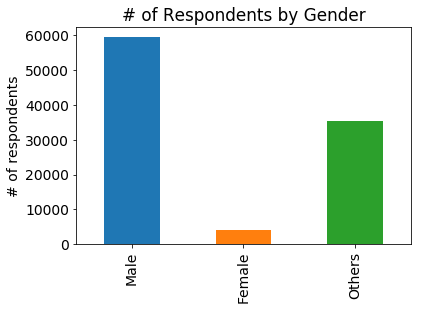

In [14]:
plot_no_of_respondants_by('Gender', gender_orders)

In [15]:
df["Gender"].value_counts()

Male      59458
Others    35373
Female     4025
Name: Gender, dtype: int64

### Entries by Age

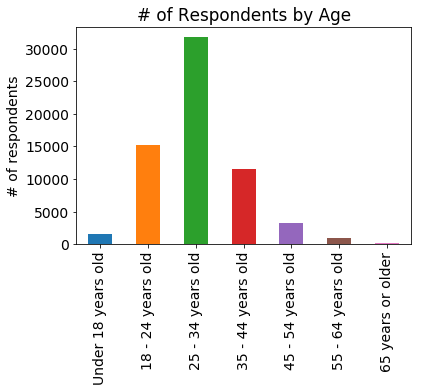

In [16]:
plot_no_of_respondants_by('Age', age_orders)

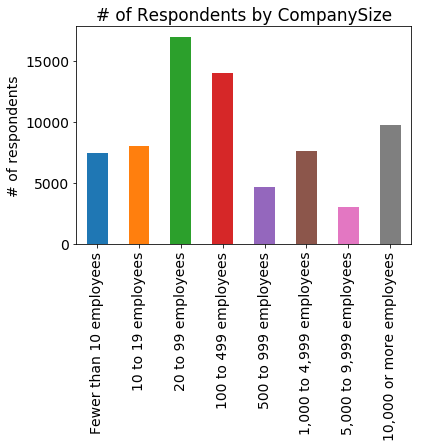

In [17]:
plot_no_of_respondants_by('CompanySize', company_size_orders)

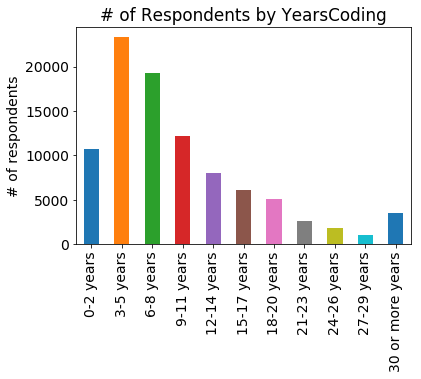

In [18]:
plot_no_of_respondants_by('YearsCoding', orders=years_coding_orders)

### Histogram of Job Satisfaction

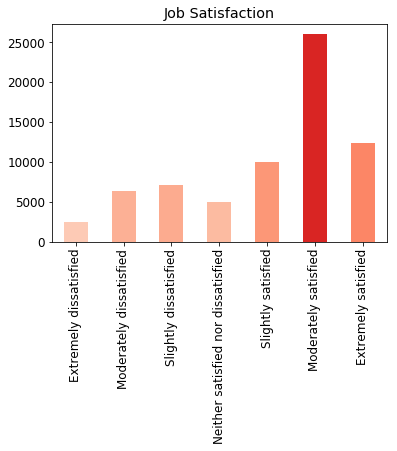

In [19]:
plt.rc('font', size=12)
def plot_satisfaction_hist():
  cat = CategoricalDtype(preprocess.satisfactions, ordered=True)
  sat = df['JobSatisfaction'].astype(cat).value_counts()[preprocess.satisfactions]
#   sat = df['JobSatisfaction'].value_counts()[preprocess.satisfactions]
  colors = cm.Reds(np.interp(sat.values, [sat.min(), sat.max()], [0.2, 0.7]))
  return sat.plot(kind='bar', title='Job Satisfaction', color=colors)
#   return sat.iplot(kind='bar', 
#                    title = 'Job Satisfaction', 
#                    color='#8A360F')

ax = plot_satisfaction_hist()

# ax.xticks(rotation=90)



Text(0.5, 1.0, '# of respondents by countries')

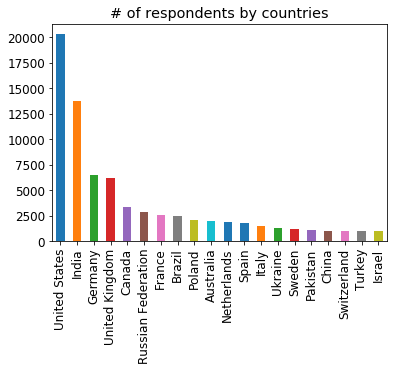

In [20]:
ax = df["Country"].value_counts().head(20).plot(kind='bar')
ax.set_title('# of respondents by countries')

### No. of respondants from top countries

[('United States', 20309), ('India', 13721), ('Germany', 6459), ('United Kingdom', 6221), ('Canada', 3393), ('Russian Federation', 2869), ('France', 2572), ('Brazil', 2505), ('Poland', 2122), ('Australia', 2018), ('Netherlands', 1841), ('Spain', 1769), ('Italy', 1535), ('Ukraine', 1279), ('Sweden', 1164), ('Pakistan', 1050), ('China', 1037), ('Switzerland', 1010), ('Turkey', 1004), ('Israel', 1003)]


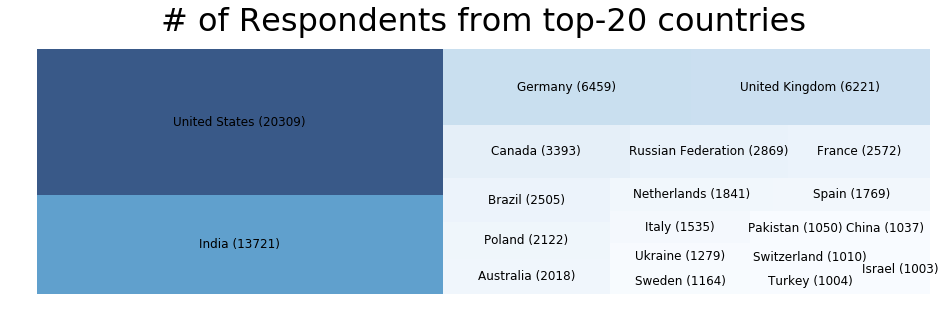

In [21]:
def plot_country_respondants(top_n = 30):
  # Get Axis and Figure
  fig, ax = plt.subplots()
  # Our Colormap
  cmap = cm.Blues
  # Min and Max Values
  country = df["Country"].value_counts().head(top_n)
  mini = min(country)
  maxi = max(country)
  # Finding Colors for each tile
  norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
  colors = [cmap(norm(value)) for value in country]
  # Plotting
  labels = map(lambda cv: "{0} ({1})".format(cv[0],cv[1]), zip(country.index, country.values))
  print(list(zip(country.index, country.values)))
  sqplt = squarify.plot(sizes=country, label=labels, alpha=0.8, color=colors)
  fig.set_size_inches(16, 4.5)
  # Removing Axis
  plt.axis('off')
  # Invert Y-Axis
  plt.gca().invert_yaxis()
  # Title
  plt.title("# of Respondents from top-{0} countries".format(top_n), fontsize=32)
  # Title Positioning
  ttl = ax.title
  ttl.set_position([.5, 1.05])
  # BG Color
  # fig.set_facecolor('#eeffee')
plot_country_respondants(20)

### Job Satisfaction by Country

In [22]:
def plot_job_satisfaction_by_country(colorscale):
  jobsat = preprocess.numerize_job_satisfaction(df[['Country', 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
  jobsat = jobsat.groupby('Country').mean()
  countries = pd.Series(jobsat['JobSatisfaction'], index=jobsat.index)

  countries = countries.to_frame().reset_index()
  countries = countries.rename(columns={'Country': 'index', 'JobSatisfaction': 'Country'})
  countries.loc[2]['code'] = 'test'
  for i,country in enumerate(countries['index']):
      user_input = country
      mapping = {country.name: country.alpha_3 for country in pycountry.countries}
      countries.set_value(i, 'code', mapping.get(user_input))

  data = [ dict(
          type = 'choropleth',
          locations = countries['code'],
          z = countries['Country'],
          text = countries['index'],
  #         color = colors,
  #         autocolorscale = False,
  #         reversescale = True,
          marker = dict(
              line = dict (
                  color = 'rgb(180,180,180)',
                  width = 0.5
              ) ),
          colorscale=colorscale,
          colorbar = dict(
              autotick = False,
              tickprefix = '',
              title = 'Job Satisfaction'),
          ) 
         ]

  layout = dict(
      title = 'Job Satisfaction by country',
      geo = dict(
          showframe = False,
          showcoastlines = False,
          projection = dict(
              type = 'Mercator'
          )
      )
  )

  fig = dict( data=data, layout=layout )
  iplot( fig, validate=False)
colorscale = [[0.0, 'rgb(165,0,38)'], [0.1111111111111111, 'rgb(215,48,39)'], [0.2222222222222222, 'rgb(244,109,67)'], [0.3333333333333333, 'rgb(253,174,97)'], [0.4444444444444444, 'rgb(254,224,144)'], [0.5555555555555556, 'rgb(224,243,248)'], [0.6666666666666666, 'rgb(171,217,233)'], [0.7777777777777778, 'rgb(116,173,209)'], [0.8888888888888888, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]
plot_job_satisfaction_by_country(colorscale)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [23]:
df.dropna(subset=['JobSatisfaction']).shape

(69276, 29)

In [24]:
utils.get_unique_categories(df['JobSatisfaction'])

{'Extremely dissatisfied',
 'Extremely satisfied',
 'Moderately dissatisfied',
 'Moderately satisfied',
 'Neither satisfied nor dissatisfied',
 'Slightly dissatisfied',
 'Slightly satisfied'}

### Actual Values

In [25]:
jobsat = preprocess.numerize_job_satisfaction(df[['Country', 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
jobsat.groupby('Country').mean().sort_values(by='JobSatisfaction', ascending=False)

JobSatisfaction
Country                                                   
Marshall Islands                                  3.000000
Tajikistan                                        2.666667
Solomon Islands                                   2.000000
Angola                                            2.000000
Suriname                                          2.000000
Sierra Leone                                      2.000000
San Marino                                        2.000000
Burundi                                           2.000000
Fiji                                              1.833333
Andorra                                           1.666667
Togo                                              1.600000
Montenegro                                        1.444444
Iraq                                              1.444444
Senegal                                           1.428571
Cyprus                                            1.424242
Norway                                            1.404598
Sweden                                            1.401345
Zambia                                            1.400000
Finland                                           1.392308
Denmark                                           1.388330
Switzerland                                       1.369369
Mauritius                                         1.352941
United Republic of Tanzania                       1.344828
Malta                                             1.339623
Monaco                                            1.333333
Netherlands                                       1.320381
Austria                                           1.279588
United States                                     1.228406
Armenia                                           1.226667
Belgium                                           1.223636
Serbia                                            1.214008
Uruguay                                           1.207792
Czech Republic                                    1.205000
Benin                                             1.200000
South Africa                                      1.198000
Canada                                            1.197368
Estonia                                           1.194444
Australia                                         1.175938
Kenya                                             1.175439
Latvia                                            1.170940
United Kingdom                                    1.159959
Slovenia                                          1.148810
Yemen                                             1.142857
Lebanon                                           1.140845
France                                            1.132209
Germany                                           1.128799
Croatia                                           1.127778
Ecuador                                           1.108108
Portugal                                          1.100775
Iceland                                           1.096774
New Zealand                                       1.089588
Israel                                            1.086471
Madagascar                                        1.076923
Poland                                            1.070588
Other Country (Not Listed Above)                  1.060000
Nicaragua                                         1.052632
Chile                                             1.039735
El Salvador                                       1.030303
Pakistan                                          1.026439
Republic of Moldova                               1.020833
Slovakia                                          1.005587
Gambia                                            1.000000
Maldives                                          1.000000
Bahrain                                           1.000000
Haiti                                             1.000000
Niger                                             1.000000
Kuwait                         

### Average Job Satisfaction by gender

In [26]:
# gender_with_male_female_others()
gender_jobsat = preprocess.numerize_job_satisfaction(df[['Gender', 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
gender_jobsat.groupby('Gender').mean()

JobSatisfaction
Gender                 
Male           1.067637
Female         1.054103
Others         0.948736

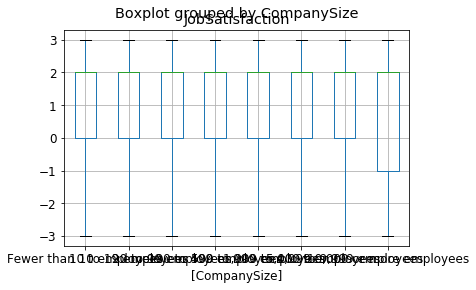

In [27]:
column = 'CompanySize'
bycol = preprocess.numerize_job_satisfaction(df[[column, 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
# bycol.groupby(['CompanySize', 'JobSatisfaction']).size().unstack()
cat = CategoricalDtype(company_size_orders, ordered=True)
bycol["CompanySize"] = bycol["CompanySize"].astype(cat)
bycol.boxplot(by='CompanySize')
# plt.boxplot(bycol[bycol["CompanySize"] == '20 to 99 employees']["JobSatisfaction"].values)
# plt.boxplot(bycol[bycol["CompanySize"] == '10 to 19 employees']["JobSatisfaction"].values)

In [262]:
def violin_plot(col, limited_to_categories=None):
  bycol = preprocess.numerize_job_satisfaction(df[[col, 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
  tips = bycol.dropna(subset=[col])
  if limited_to_categories is not None:
    tips = tips[tips[col].isin(limited_to_categories)]

  ax = sns.violinplot(x=col, y="JobSatisfaction", data=tips)
  if limited_to_categories is not None:
    ax.set_xticklabels(limited_to_categories, rotation=90)
  return ax

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



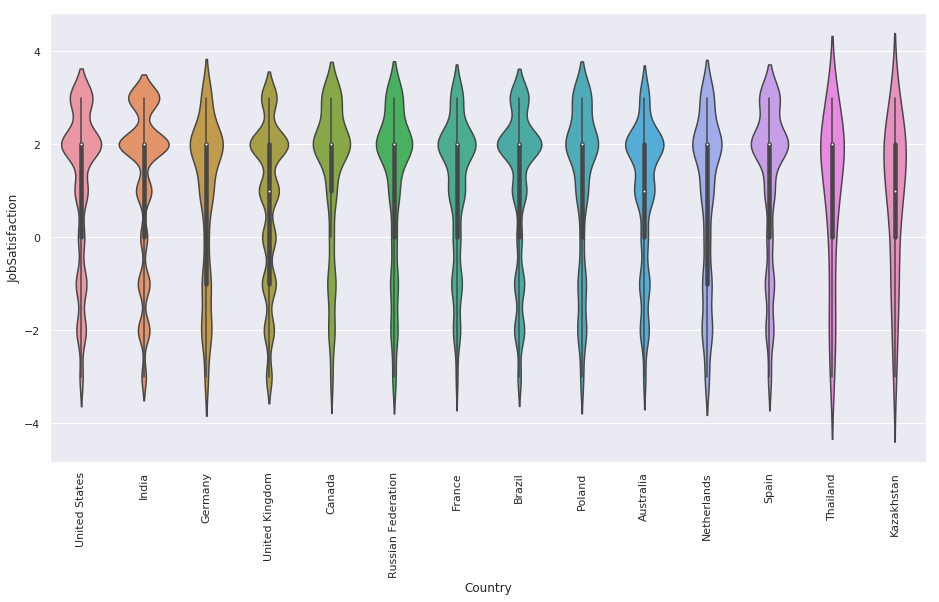

In [273]:
violin_plot('Country', list(df["Country"].value_counts()[:12].index) + ['Thailand', 'Kazakhstan'])

In [265]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
violin_plot('CompanySize')

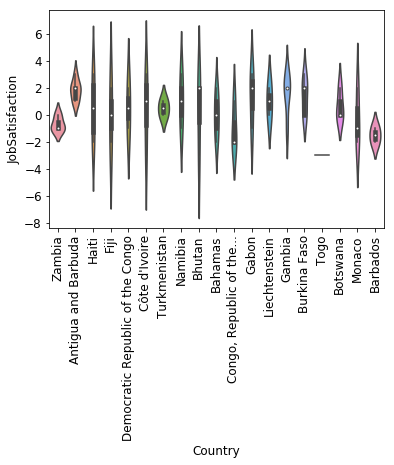

In [31]:
violin_plot('Country', limited_to_categories=df["Country"].value_counts()[-50:-30].index)

In [32]:
df["Country"].value_counts()[:20].index

Index(['United States', 'India', 'Germany', 'United Kingdom', 'Canada',
       'Russian Federation', 'France', 'Brazil', 'Poland', 'Australia',
       'Netherlands', 'Spain', 'Italy', 'Ukraine', 'Sweden', 'Pakistan',
       'China', 'Switzerland', 'Turkey', 'Israel'],
      dtype='object')

In [33]:
utils.get_unique_categories(df['CompanySize'])

{'1,000 to 4,999 employees',
 '10 to 19 employees',
 '10,000 or more employees',
 '100 to 499 employees',
 '20 to 99 employees',
 '5,000 to 9,999 employees',
 '500 to 999 employees',
 'Fewer than 10 employees'}

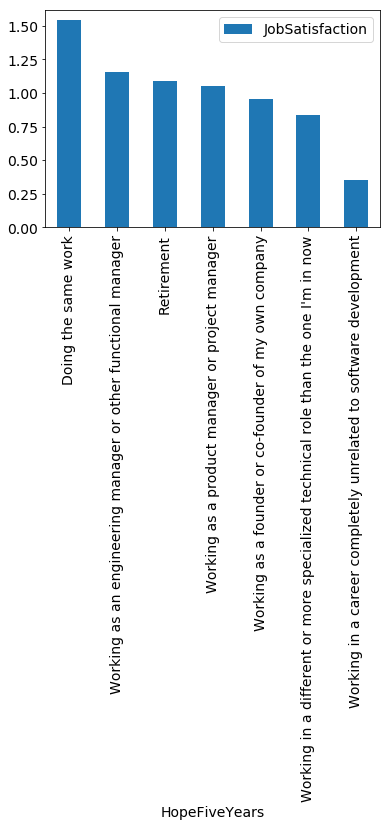

In [218]:
column = "HopeFiveYears"
bycol = preprocess.numerize_job_satisfaction(df[[column, 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
bycol = bycol.groupby(column).mean().sort_values(by='JobSatisfaction', ascending=False)
bycol.plot(kind='bar')

In [232]:
average_job_satisfaction_by('Country').sort_values('JobSatisfaction')

JobSatisfaction
Country                                                   
Afghanistan                                      -0.052632
Albania                                           0.937500
Algeria                                           0.288889
Andorra                                           1.666667
Angola                                            2.000000
Antigua and Barbuda                              -1.500000
Argentina                                         0.934066
Armenia                                           1.226667
Australia                                         1.175938
Austria                                           1.279588
Azerbaijan                                        0.608696
Bahamas                                          -1.000000
Bahrain                                           1.000000
Bangladesh                                        0.628571
Barbados                                          0.500000
Belarus                                           0.776316
Belgium                                           1.223636
Belize                                           -1.000000
Benin                                             1.200000
Bhutan                                            0.333333
Bolivia                                           0.869565
Bosnia and Herzegovina                            0.977778
Botswana                                         -0.666667
Brazil                                            0.813483
Bulgaria                                          0.981538
Burkina Faso                                     -3.000000
Burundi                                           2.000000
Cambodia                                          0.920000
Cameroon                                          0.315789
Canada                                            1.197368
Central African Republic                         -1.000000
Chile                                             1.039735
China                                             0.116090
Colombia                                          0.836653
Congo, Republic of the...                        -0.333333
Costa Rica                                        0.785714
Croatia                                           1.127778
Cuba                                              0.021277
Cyprus                                            1.424242
Czech Republic                                    1.205000
Côte d'Ivoire                                     0.000000
Democratic Republic of the Congo                  0.666667
Denmark                                           1.388330
Dominica                                         -3.000000
Dominican Republic                                0.475000
Ecuador                                           1.108108
Egypt                                             0.641921
El Salvador                                       1.030303
Estonia                                           1.194444
Ethiopia                                          0.333333
Fiji                                              1.833333
Finland                                           1.392308
France                                            1.132209
Gabon                                             0.500000
Gambia                                            1.000000
Georgia                                           0.634146
Germany                                           1.128799
Ghana                                             0.695652
Greece                                            0.976471
Grenada                                          -1.000000
Guatemala                                         0.736842
Guinea                                            0.000000
Guyana                                           -2.000000
Haiti                                             1.000000
Honduras                                          0.400000
Hong Kong (S.A.R.)                                0.565789
Hungary                        

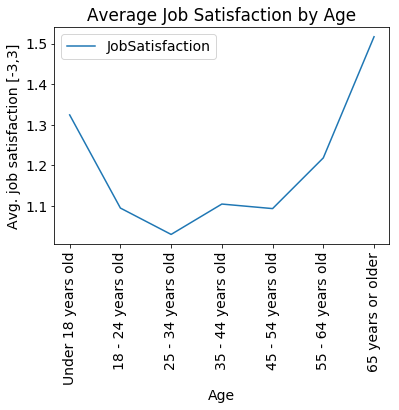

In [237]:
def average_job_satisfaction_by(column, orders=None):
  bycol = preprocess.numerize_job_satisfaction(df[[column, 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
  bycol = bycol.groupby(column).mean()
  if orders:
    return bycol.reindex(orders)
  else:
    return bycol
  
def plot_average_job_satisfaction_by(column, plot_kind, orders=None, sort=None, figsize=None):
  d = average_job_satisfaction_by(column, orders)
  if orders is None and sort:
    d = d.sort_values(by='JobSatisfaction')
  ax = d.plot(kind=plot_kind, figsize=figsize)
  ax.set_ylabel('Avg. job satisfaction [-3,3]')
  if orders is not None:
    ax.set_xticks(range(len(orders)))
    ax.set_xticklabels(orders, rotation=90)
  ax.set_title('Average Job Satisfaction by ' + column)
  return ax
  
def line_plot_average_job_satisfaction_by(column, orders=None):
  return plot_average_job_satisfaction_by(column, 'line', orders)
  
def bar_plot_average_job_satisfaction_by(column, orders=None, sort=False, figsize=None):
  return plot_average_job_satisfaction_by(column, 'bar', orders, sort, figsize)

  
line_plot_average_job_satisfaction_by('Age', age_orders)

In [76]:
age_orders

['Under 18 years old',
 '18 - 24 years old',
 '25 - 34 years old',
 '35 - 44 years old',
 '45 - 54 years old',
 '55 - 64 years old',
 '65 years or older']

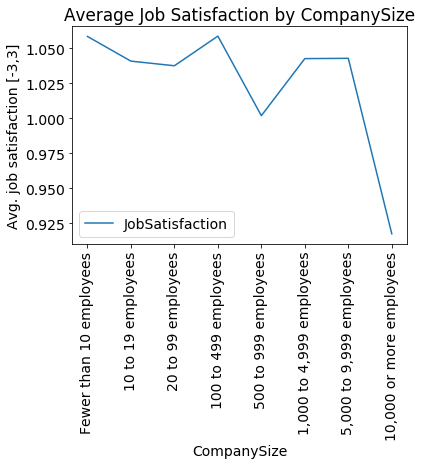

In [77]:
line_plot_average_job_satisfaction_by('CompanySize', company_size_orders)

In [78]:
waketime_orders = [
  'Before 5:00 AM',
  'Between 5:00 - 6:00 AM',
  'Between 6:01 - 7:00 AM',
  'Between 7:01 - 8:00 AM',
  'Between 8:01 - 9:00 AM',
  'Between 9:01 - 10:00 AM',
  'Between 10:01 - 11:00 AM',
  'Between 11:01 AM - 12:00 PM',
  'After 12:01 PM',
  'I work night shifts',
 'I do not have a set schedule']
waketime_orders_9_5 = waketime_orders[:9]

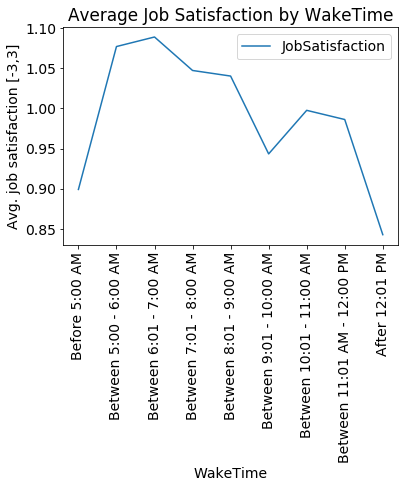

In [79]:
line_plot_average_job_satisfaction_by('WakeTime', waketime_orders_9_5)

In [67]:
waketime_orders_9_5

['Before 5:00 AM',
 'Between 5:00 - 6:00 AM',
 'Between 6:01 - 7:00 AM',
 'Between 7:01 - 8:00 AM',
 'Between 8:01 - 9:00 AM',
 'Between 9:01 - 10:00 AM',
 'Between 10:01 - 11:00 AM',
 'Between 11:01 AM - 12:00 PM',
 'After 12:01 PM']

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



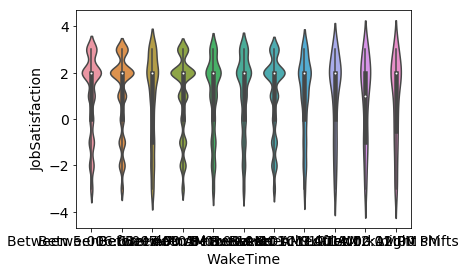

In [65]:
violin_plot('WakeTime')

In [63]:
list(utils.get_unique_categories(df['WakeTime']))

['Between 5:00 - 6:00 AM',
 'Between 10:01 - 11:00 AM',
 'Between 8:01 - 9:00 AM',
 'I work night shifts',
 'Between 7:01 - 8:00 AM',
 'After 12:01 PM',
 'Between 11:01 AM - 12:00 PM',
 'Before 5:00 AM',
 'Between 9:01 - 10:00 AM',
 'Between 6:01 - 7:00 AM',
 'I do not have a set schedule']

In [36]:
preprocess.numerize_job_satisfaction(df.dropna(subset=['JobSatisfaction'])).groupby('WakeTime').mean().drop(columns=['ConvertedSalary'])

JobSatisfaction
WakeTime                                     
After 12:01 PM                       0.843137
Before 5:00 AM                       0.899329
Between 10:01 - 11:00 AM             0.997608
Between 11:01 AM - 12:00 PM          0.986207
Between 5:00 - 6:00 AM               1.076861
Between 6:01 - 7:00 AM               1.088729
Between 7:01 - 8:00 AM               1.047127
Between 8:01 - 9:00 AM               1.040193
Between 9:01 - 10:00 AM              0.943493
I do not have a set schedule         1.098749
I work night shifts                  0.830918

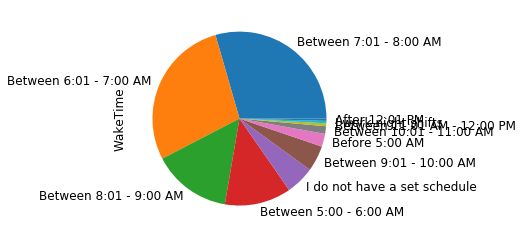

In [37]:
df['WakeTime'].value_counts().plot(kind='pie')

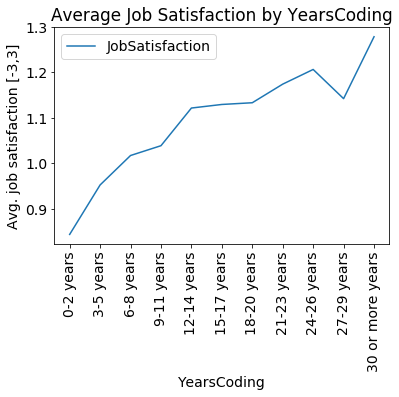

In [80]:
line_plot_average_job_satisfaction_by('YearsCoding', years_coding_orders)

(0.7, 1.111654128539911)

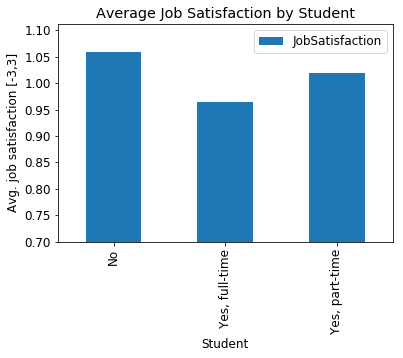

In [39]:
ax = bar_plot_average_job_satisfaction_by('Student')
ax.set_ylim(0.7)

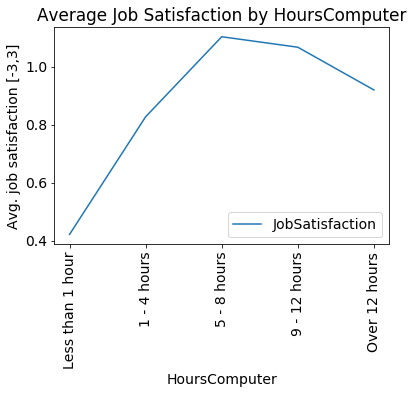

In [81]:
# plot_no_of_respondants_by('HoursComputer', orders=hours_computer_orders)
line_plot_average_job_satisfaction_by('HoursComputer', orders=hours_computer_orders)

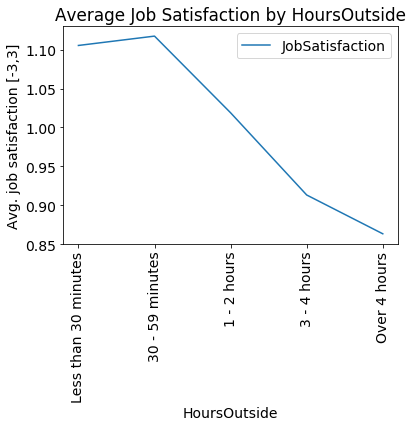

In [82]:
line_plot_average_job_satisfaction_by('HoursOutside', orders=hours_outside_orders)

In [42]:
jobsat

Country  JobSatisfaction
0                             Kenya                3
1                    United Kingdom               -2
2                     United States                2
3                     United States                0
4                      South Africa                1
5                    United Kingdom                2
6                     United States                1
7                           Nigeria                1
8                     United States                2
10                            Spain               -2
13                            India                3
14                      Netherlands                0
15                           Israel               -2
17                           Sweden                2
18                            India                1
20                        Australia                1
21                    United States                3
22                   United Kingdom                1
23                    United States               -1
24                            India                2
25                           Greece               -1
26                           Sweden                2
27                    United States                2
28                    United States                3
29                   United Kingdom                0
30                           Poland                1
31                           Sweden                1
32                    United States               -3
33                    United States               -2
35                    United States                2
36                   United Kingdom                3
37                          Belgium               -1
38                        Argentina                0
39                    United States                0
41                            India                1
43                    United States                3
44                            India               -1
45                            India                2
46                    United States                1
47                    United States               -3
48                        Indonesia                1
49                    United States                2
51                    United States                2
52                    United States               -2
53                          Germany                2
54                            India                2
55                          Germany                1
56                          Ireland                2
57                           France                0
58                          Ukraine               -1
60                          Denmark                0
61                    United States                1
62                    United States                2
63                          Germany               -1
65                            China               -2
67                    United States                2
69               Russian Federation               -1
70                            China                0
71                           Latvia                1
72                          Algeria                2
73                    United States                2
75                    United States                2
76                         Colombia                1
78                            India                2
79                   United Kingdom               -1
80                            Japan                2
81                           France                2
82                   United Kingdom                2
83                        Indonesia               -2
84                        Argentina                3
85                    United States                0
86                    United States                0
87               Russian Federation                2
88                          Finland                3
90                           Poland                2


Text(0, 0.5, 'Satisfaction from [-3,3]')

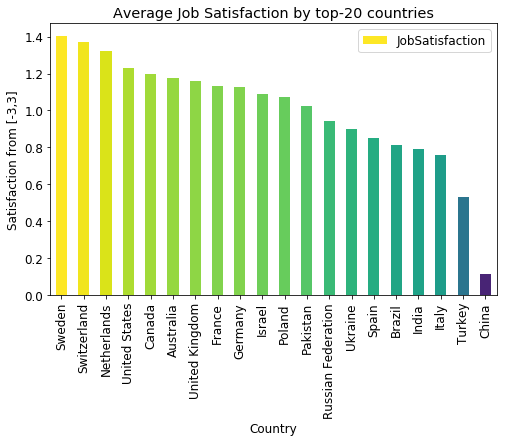

In [43]:
N = 20
topN = df['Country'].value_counts()[:N]
jobsat = preprocess.numerize_job_satisfaction(df[['Country', 'JobSatisfaction', 'Gender']].dropna(subset=['JobSatisfaction']))
jobsat = jobsat[jobsat['Country'].isin(topN.index)]

sat = jobsat.groupby(['Country']).mean().sort_values(by='JobSatisfaction', ascending=False)
interp = np.interp(sat['JobSatisfaction'].values, [sat.values.min(), sat.values.max()], [0.1, 1.0])
colors = cm.viridis(interp)

ax = sat.plot(kind='bar', figsize=(8, 5), color=[colors])
ax.set_title('Average Job Satisfaction by top-{0} countries'.format(N))
ax.set_ylabel('Satisfaction from [-3,3]')
# ax.set_ylim(0.0)

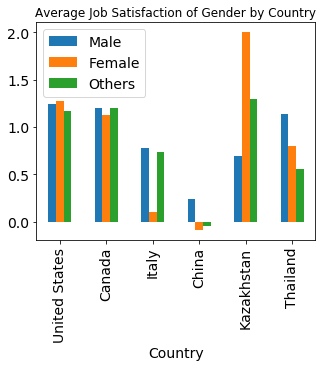

In [44]:
def compare_two_columns(col1, col2, topN=None, title=None, only_values=None):
  if title is None:
    title = 'Average Job Satisfaction of {1} by {0}'.format(col1, col2)
  topN = df[col1].value_counts()[:topN]
  jobsat = preprocess.numerize_job_satisfaction(df[[col1, col2, 'JobSatisfaction']].dropna(subset=['JobSatisfaction']))
  jobsat = jobsat[jobsat[col1].isin(topN.index)]
  jobsatcols = jobsat.groupby([col1, col2]).mean().unstack()
  if only_values is not None:
    jobsatcols = jobsatcols.reindex(only_values)
  ax = jobsatcols.plot(kind='bar', figsize=(5, 4))
  ax.legend(jobsatcols.columns.levels[1].tolist())
  plt.title(title, fontsize=12)
  return ax

plt.rc('font', size=14)
only_countries = ['United States', 'Canada', 'Italy', 'China', 'Kazakhstan', 'Thailand']
compare_two_columns('Country', 'Gender', None, only_values=only_countries)

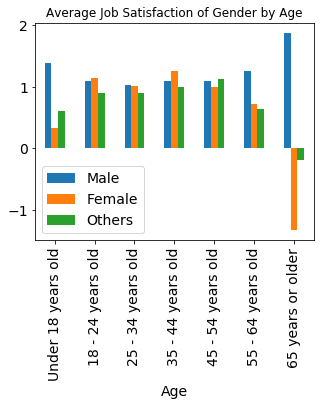

In [45]:
compare_two_columns('Age', 'Gender')

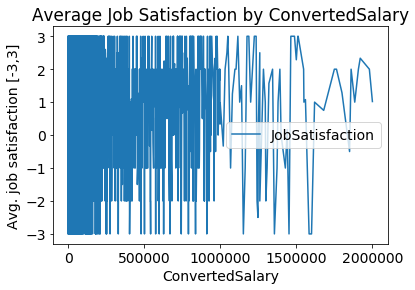

In [85]:
line_plot_average_job_satisfaction_by("ConvertedSalary")

In [53]:
def barplot_multi_categories(col, title=None):
  satisfaction_by_devtypes=[]
  for devtype in utils.get_unique_categories(df[col]):
    df2 = df.copy() 
    df2[col] = df2[col].str.split(';') 
    contains_dev = df2[col].apply(lambda x: devtype in x if type(x) is list else False)
    avgsat = preprocess.numerize_job_satisfaction(df2[contains_dev])['JobSatisfaction'].mean()
    satisfaction_by_devtypes.append((devtype, avgsat))
  satdevs = sorted(satisfaction_by_devtypes, key=lambda x: x[1], reverse=True)
  vals = list(map(lambda x: x[1], satdevs))
  inds = list(map(lambda x: x[0], satdevs))
  return pd.DataFrame(vals, index=inds).plot(kind='bar', figsize=(10,5), title=title, legend=False)

In [54]:
Columns.work

['CompanySize',
 'DevType',
 'LanguageWorkedWith',
 'DatabaseWorkedWith',
 'PlatformWorkedWith',
 'OperatingSystem']

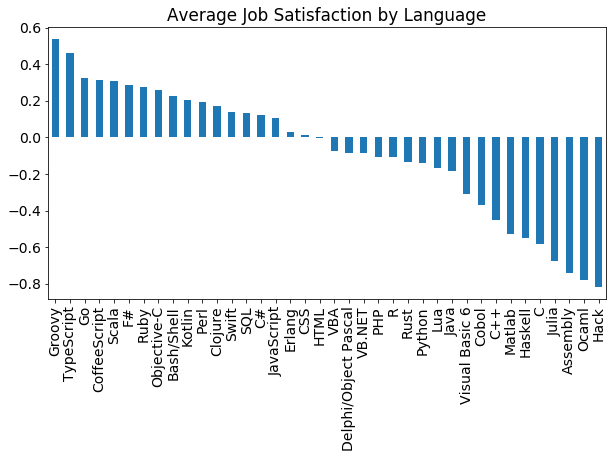

In [56]:
barplot_multi_categories('LanguageWorkedWith', title="Average Job Satisfaction by Language")

In [49]:
Columns.all

['JobSatisfaction',
 'ConvertedSalary',
 'Country',
 'RaceEthnicity',
 'Gender',
 'Age',
 'Student',
 'Employment',
 'FormalEducation',
 'UndergradMajor',
 'YearsCoding',
 'JobSearchStatus',
 'LastNewJob',
 'EducationTypes',
 'EducationParents',
 'CompanySize',
 'DevType',
 'LanguageWorkedWith',
 'DatabaseWorkedWith',
 'PlatformWorkedWith',
 'OperatingSystem',
 'WakeTime',
 'HoursComputer',
 'HoursOutside',
 'Hobby',
 'SkipMeals',
 'OpenSource',
 'ErgonomicDevices',
 'Exercise']

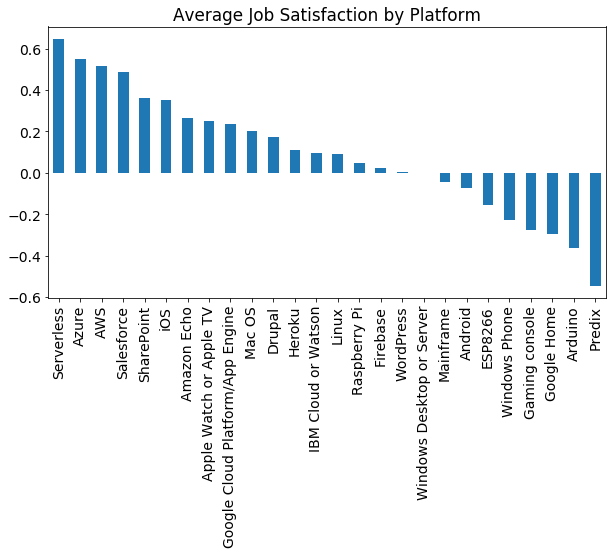

In [57]:
barplot_multi_categories('PlatformWorkedWith', title="Average Job Satisfaction by Platform")

In [204]:
hope_orders = ['Working as a product manager or project manager',
 'Working as an engineering manager or other functional manager',
 'Doing the same work',
 'Retirement',
 'Working as a founder or co-founder of my own company',
 "Working in a different or more specialized technical role than the one I'm in now",
 'Working in a career completely unrelated to software development']

In [205]:
hope_orders

['Working as a product manager or project manager',
 'Working as an engineering manager or other functional manager',
 'Doing the same work',
 'Retirement',
 'Working as a founder or co-founder of my own company',
 "Working in a different or more specialized technical role than the one I'm in now",
 'Working in a career completely unrelated to software development']

In [203]:
list(utils.get_unique_categories(df["HopeFiveYears"]))

['Working as a product manager or project manager',
 'Working as an engineering manager or other functional manager',
 'Doing the same work',
 'Retirement',
 'Working as a founder or co-founder of my own company',
 "Working in a different or more specialized technical role than the one I'm in now",
 'Working in a career completely unrelated to software development']

In [212]:
df["HopeFiveYears"].dropna().value_counts()

Working in a different or more specialized technical role than the one I'm in now    25643
Working as a founder or co-founder of my own company                                 19444
Doing the same work                                                                  14724
Working as an engineering manager or other functional manager                         7483
Working as a product manager or project manager                                       5004
Working in a career completely unrelated to software development                      2151
Retirement                                                                            1269
Name: HopeFiveYears, dtype: int64

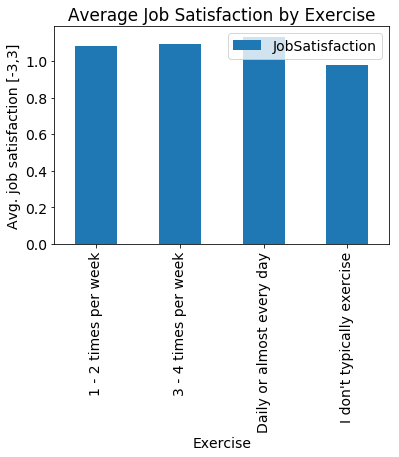

In [221]:
bar_plot_average_job_satisfaction_by('Exercise')

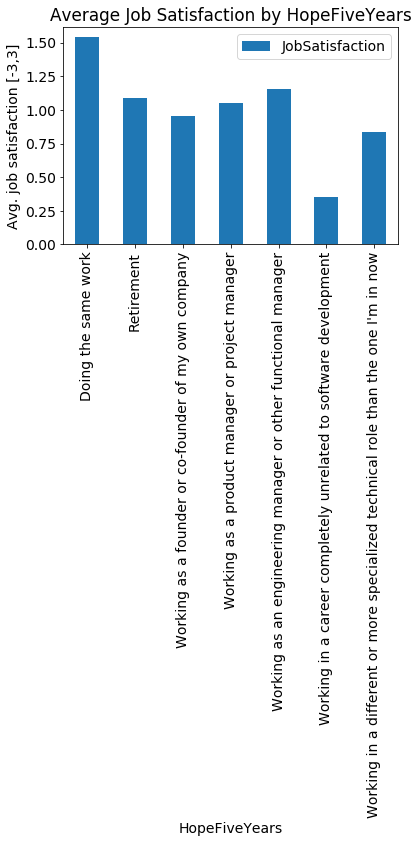

In [208]:
bar_plot_average_job_satisfaction_by("HopeFiveYears")

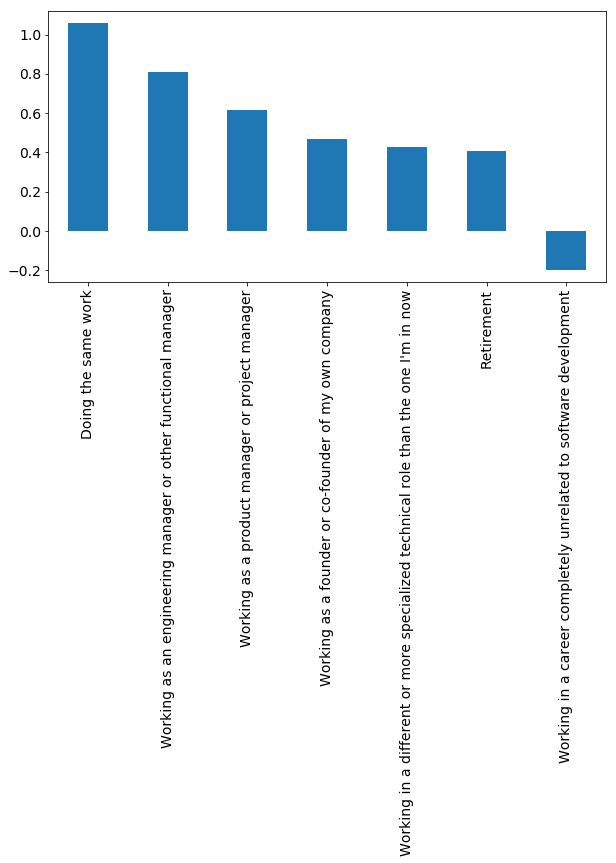

In [206]:
barplot_multi_categories("HopeFiveYears")

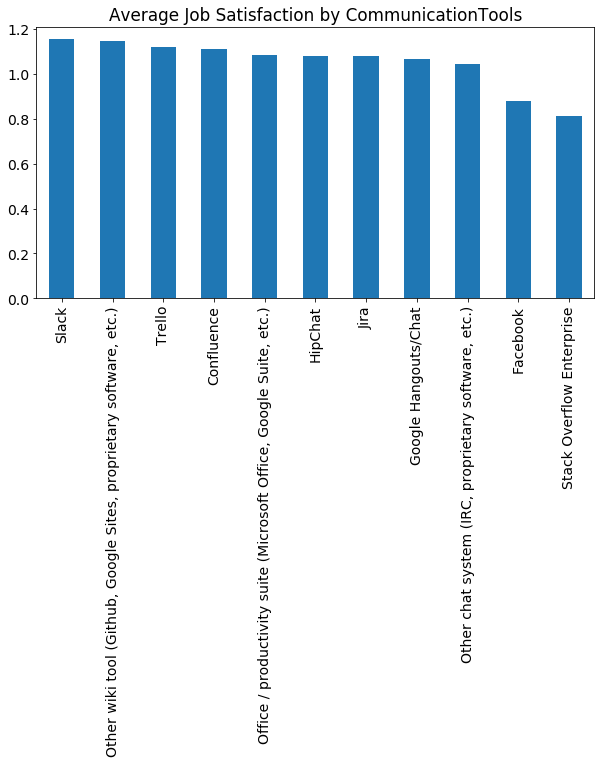

In [196]:
barplot_multi_categories('CommunicationTools', title="Average Job Satisfaction by CommunicationTools")

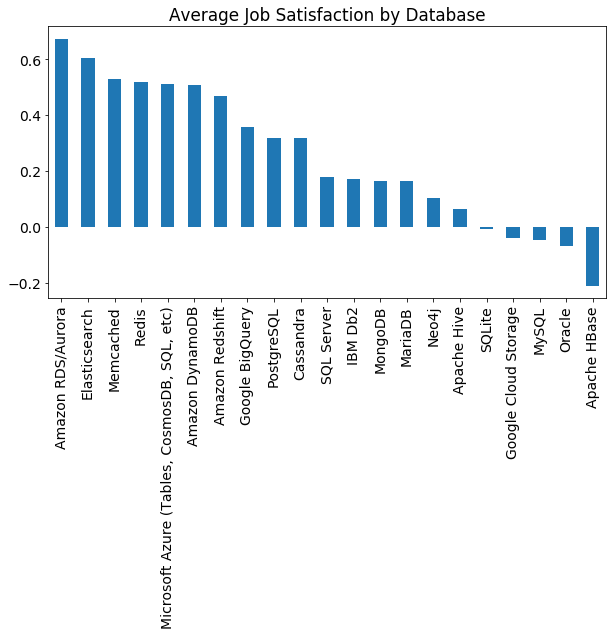

In [59]:
barplot_multi_categories('DatabaseWorkedWith', title="Average Job Satisfaction by Database")

(1.3, 1.9747831529572573)

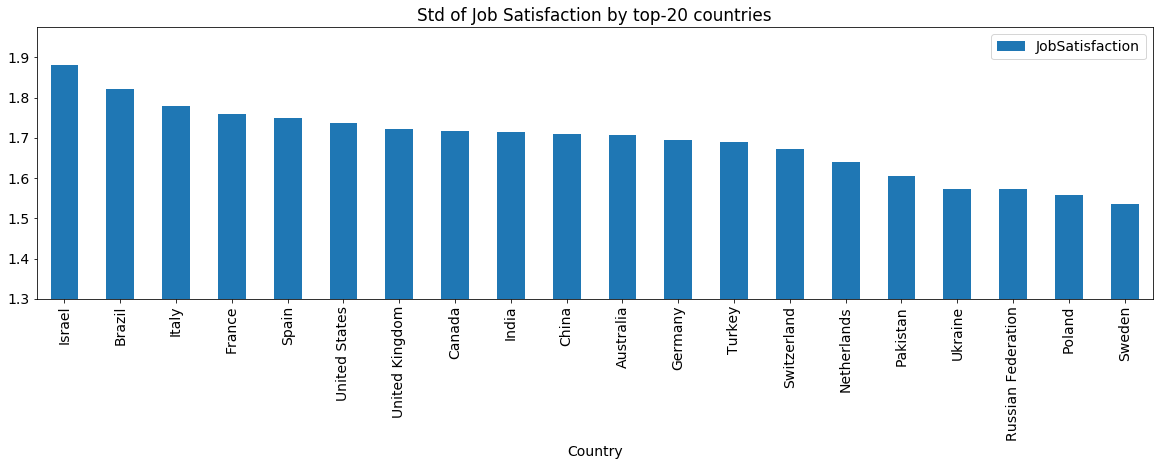

In [51]:
ax = jobsat.groupby('Country').std().sort_values(by='JobSatisfaction', ascending=False).plot(kind='bar', figsize=(20, 5))
ax.set_title('Std of Job Satisfaction by top-{0} countries'.format(N))
ax.set_ylim(1.3)

In [100]:
bycol = preprocess.numerize_job_satisfaction(df[["ConvertedSalary", 'JobSatisfaction']].dropna(subset=['JobSatisfaction', 'ConvertedSalary']))
# Xy = bycol.sort_values(by='ConvertedSalary')
# Xy.iloc[:,1]
bycol.groupby('ConvertedSalary').mean()

JobSatisfaction
ConvertedSalary                 
0.0                     0.878947
1.0                    -1.000000
3.0                    -3.000000
4.0                    -1.000000
5.0                     1.000000
12.0                    1.000000
15.0                    2.000000
24.0                    0.333333
25.0                    2.000000
26.0                    2.000000
30.0                    0.000000
33.0                   -1.000000
35.0                    2.000000
36.0                    0.857143
38.0                    1.000000
40.0                    1.000000
48.0                   -0.200000
50.0                    1.000000
53.0                    2.000000
54.0                   -1.000000
60.0                    3.000000
65.0                    3.000000
71.0                    2.000000
72.0                    2.250000
73.0                    3.000000
82.0                    2.000000
83.0                    0.500000
88.0                    2.000000
95.0                   -1.000000
96.0                   -1.000000
98.0                    2.000000
100.0                   2.000000
101.0                   2.000000
108.0                   2.000000
110.0                   1.000000
112.0                  -1.000000
115.0                  -0.500000
120.0                  -1.000000
128.0                   3.000000
130.0                   1.000000
132.0                   0.600000
133.0                   2.000000
135.0                   2.000000
136.0                   3.000000
139.0                  -3.000000
140.0                   1.000000
144.0                   1.000000
145.0                   3.000000
150.0                  -3.000000
156.0                  -3.000000
168.0                   1.000000
175.0                   2.000000
180.0                   3.000000
192.0                  -1.000000
228.0                   3.000000
236.0                  -1.000000
264.0                   0.800000
265.0                   0.000000
276.0                   0.500000
288.0                   2.000000
300.0                  -0.333333
312.0                   3.000000
313.0                   1.500000
336.0                   0.750000
360.0                   1.500000
372.0                   2.000000
407.0                   2.000000
417.0                  -3.000000
420.0                   1.333333
444.0                  -0.333333
456.0                  -3.000000
468.0                   0.666667
480.0                   1.000000
487.0                   2.000000
500.0                   0.400000
504.0                  -0.333333
531.0                   1.000000
564.0                   1.666667
587.0                  -3.000000
600.0                   0.000000
626.0                   2.000000
636.0                   0.000000
660.0                   0.583333
672.0                  -1.000000
696.0                   2.000000
701.0                   2.000000
720.0                   2.000000
732.0                   0.666667
756.0                   1.000000
780.0                   3.000000
783.0                  -1.000000
791.0                   0.000000
792.0                   0.000000
796.0                   3.000000
800.0                   3.000000
828.0                  -0.750000
833.0                   2.000000
840.0                   0.000000
850.0                   0.500000
863.0                   2.000000
...                          ...
911700.0               -3.000000
916440.0                3.000000
916476.0                1.000000
916764.0                0.428571
917904.0               -2.000000
918168.0                2.000000
919200.0                2.000000
925248.0                0.500000
925908.0                1.000000
927024.0               -1.000000
927600.0               -2.000000
930000.0                2.000000
931152.0                3.000000
933432.0                2.000000
935748.0               -0.500000
936000.0                3.000000
938424.0                2.000000
939264.0                0.000000
939936.0                

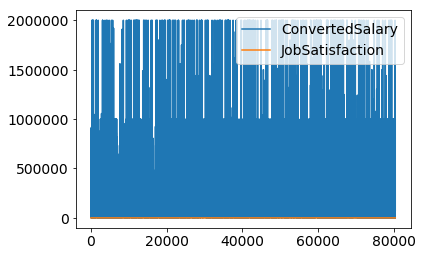

### All Orders

In [160]:
df2 = utils.load_dataset()[0][Columns.all]

In [170]:
def explore_cov(df2):
  df2 = df2.copy()
  cols = ['JobSatisfaction', 'Age', 'YearsCoding', 'CompanySize', 'HoursOutside', 'HoursComputer']
  df2 = df2.dropna(subset=cols)[cols]
  df2 = preprocess.numerize_job_satisfaction(df2)
  df2 = preprocess.numerize_column_with_orders(df2, "YearsCoding", years_coding_orders)
  df2 = preprocess.numerize_column_with_orders(df2, "CompanySize", company_size_orders)
  df2 = preprocess.numerize_column_with_orders(df2, "Age", age_orders)
  df2 = preprocess.numerize_column_with_orders(df2, "HoursOutside", hours_outside_orders)
  df2 = preprocess.numerize_column_with_orders(df2, "HoursComputer", hours_computer_orders)
  return df2
# explore_cov().corr().style.background_gradient()
df2_numeric = explore_cov(df2)
corr = df2_numeric.corr()

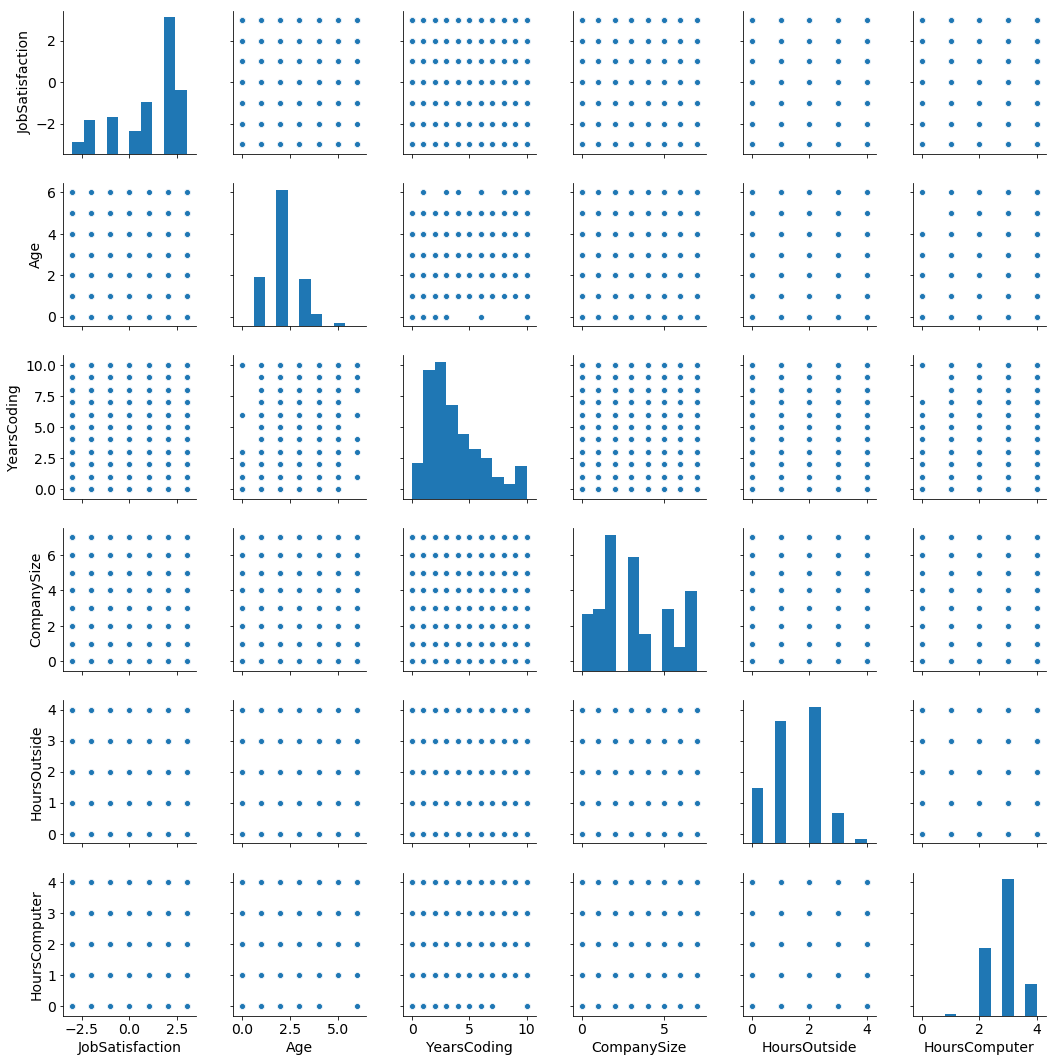

In [172]:
# with regression
sns.pairplot(df2_numeric, kind="scatter")
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



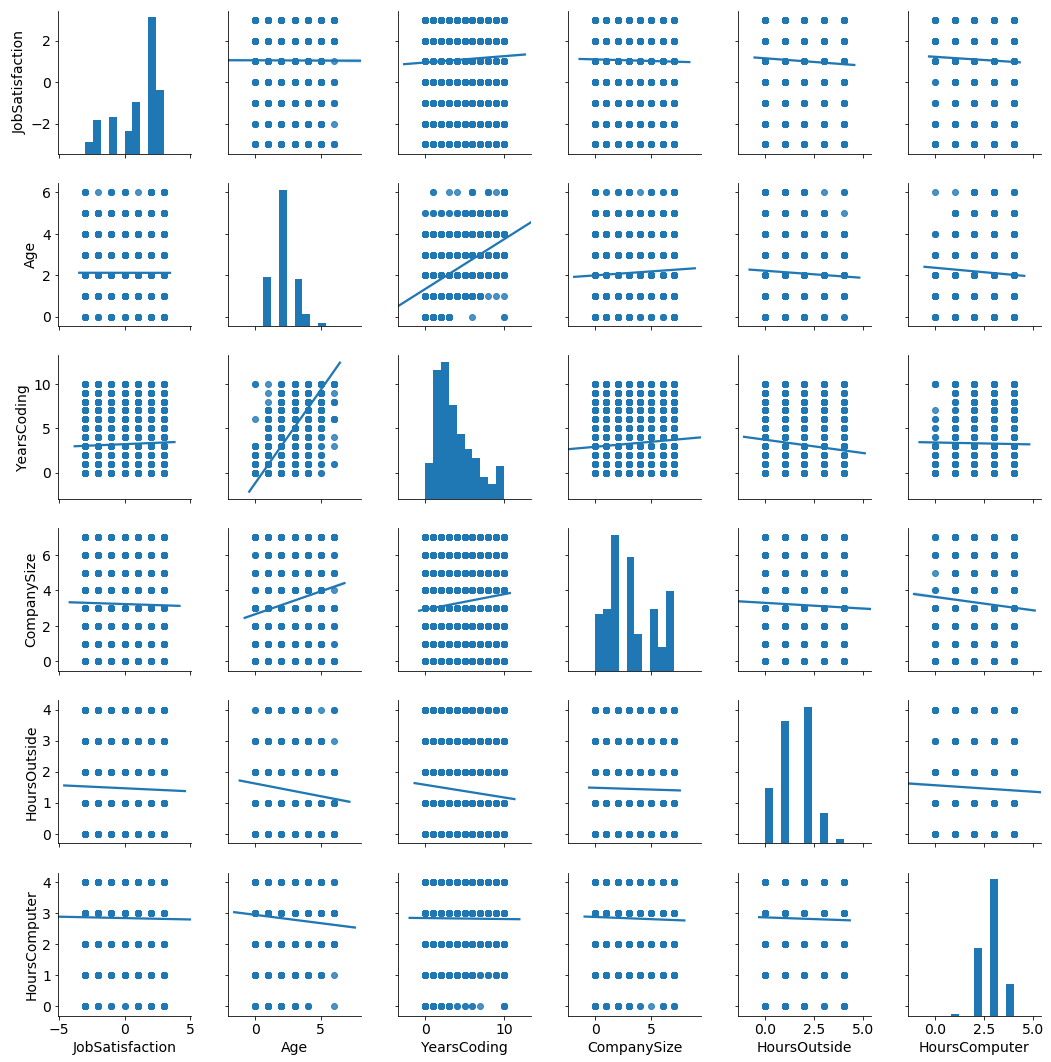

In [171]:
# with regression
sns.pairplot(df2_numeric, kind="reg")
plt.show()

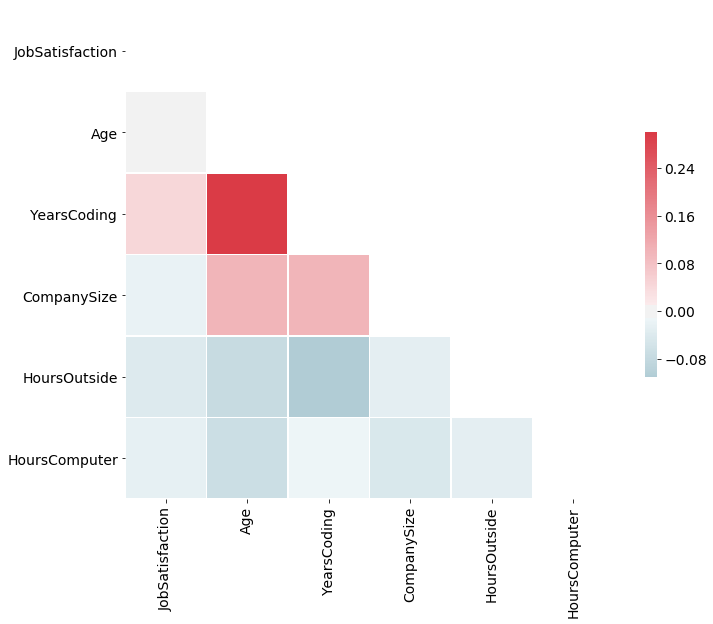

In [169]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [180]:
[1 for h in header if "Member" in h]

[]

In [181]:
header

Column  \
0                     Respondent   
1                          Hobby   
2                     OpenSource   
3                        Country   
4                        Student   
5                     Employment   
6                FormalEducation   
7                 UndergradMajor   
8                    CompanySize   
9                        DevType   
10                   YearsCoding   
11               YearsCodingProf   
12               JobSatisfaction   
13            CareerSatisfaction   
14                 HopeFiveYears   
15               JobSearchStatus   
16                    LastNewJob   
17                    AssessJob1   
18                    AssessJob2   
19                    AssessJob3   
20                    AssessJob4   
21                    AssessJob5   
22                    AssessJob6   
23                    AssessJob7   
24                    AssessJob8   
25                    AssessJob9   
26                   AssessJob10   
27               AssessBenefits1   
28               AssessBenefits2   
29               AssessBenefits3   
30               AssessBenefits4   
31               AssessBenefits5   
32               AssessBenefits6   
33               AssessBenefits7   
34               AssessBenefits8   
35               AssessBenefits9   
36              AssessBenefits10   
37              AssessBenefits11   
38         JobContactPriorities1   
39         JobContactPriorities2   
40         JobContactPriorities3   
41         JobContactPriorities4   
42         JobContactPriorities5   
43           JobEmailPriorities1   
44           JobEmailPriorities2   
45           JobEmailPriorities3   
46           JobEmailPriorities4   
47           JobEmailPriorities5   
48           JobEmailPriorities6   
49           JobEmailPriorities7   
50                      UpdateCV   
51                      Currency   
52                        Salary   
53                    SalaryType   
54               ConvertedSalary   
55                CurrencySymbol   
56            CommunicationTools   
57           TimeFullyProductive   
58                EducationTypes   
59               SelfTaughtTypes   
60             TimeAfterBootcamp   
61              HackathonReasons   
62                AgreeDisagree1   
63                AgreeDisagree2   
64                AgreeDisagree3   
65            LanguageWorkedWith   
66        LanguageDesireNextYear   
67            DatabaseWorkedWith   
68        DatabaseDesireNextYear   
69            PlatformWorkedWith   
70        PlatformDesireNextYear   
71           FrameworkWorkedWith   
72       FrameworkDesireNextYear   
73                           IDE   
74               OperatingSystem   
75                NumberMonitors   
76                   Methodology   
77                VersionControl   
78                   CheckInCode   
79                     AdBlocker   
80              AdBlockerDisable   
81              AdBlockerReasons   
82             AdsAgreeDisagree1   
83             AdsAgreeDisagree2   
84             AdsAgreeDisagree3   
85                    AdsActions   
86                AdsPriorities1   
87                AdsPriorities2   
88                AdsPriorities3   
89                AdsPriorities4   
90                AdsPriorities5   
91                AdsPriorities6   
92                AdsPriorities7   
93                   AIDangerous   
94                 AIInteresting   
95                 AIResponsible   
96                      AIFuture   
97                  EthicsChoice   
98                  EthicsReport   
99             EthicsResponsible   
100          EthicalImplications   
101       StackOverflowRecommend   
102           StackOverflowVisit   
103      StackOverflowHasAccount   
104     StackOverflowParticipate   
105            StackOverflowJobs   
106        StackOverflowDevStory   
107   StackOverflowJobsRecommend   
108  StackOverflowConsiderMember   
109           HypotheticalTools1   
110           HypotheticalTool

In [184]:
df3 = utils.load_dataset()[0]

AttributeError: 'Series' object has no attribute 'nonnan'

In [191]:
(~df3["StackOverflowConsiderMember"].isna())

76007

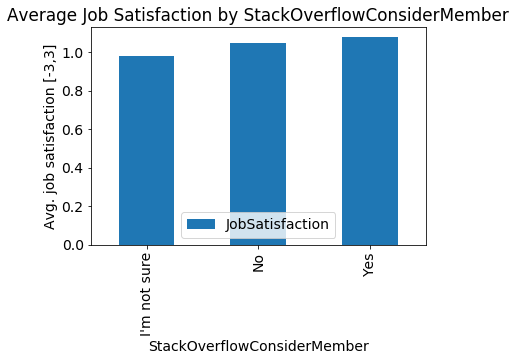

In [195]:
bar_plot_average_job_satisfaction_by("StackOverflowConsiderMember")

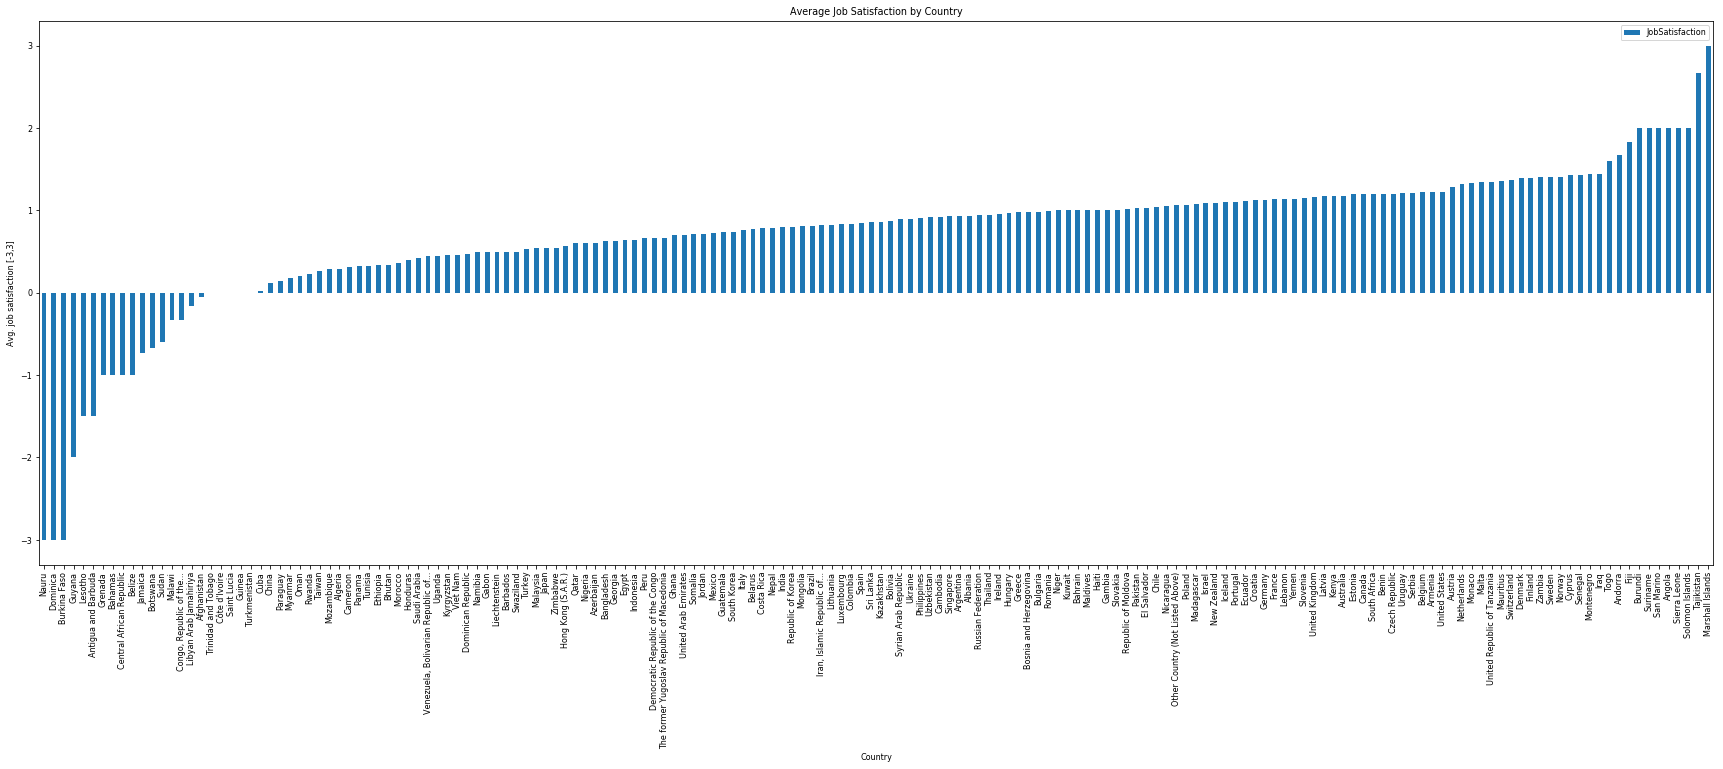

In [242]:
plt.rc('font', size=8)
ax = bar_plot_average_job_satisfaction_by('Country', sort=True, figsize=(30,10))

In [235]:
ax

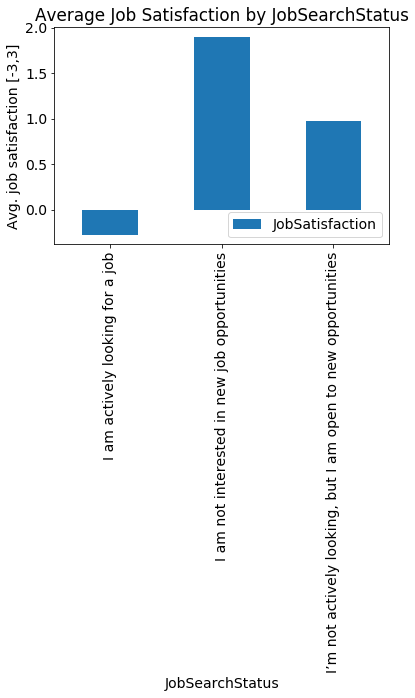

In [234]:
bar_plot_average_job_satisfaction_by('JobSearchStatus')